In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In this short Notebook, we construct a data set containing for each city the distance to the nearest ocean. For this, we have a shapefile containing coastlines which can be download as a `geopandas` DataFrame.

In [2]:
coastline_df = gpd.read_file(os.path.join('ne_10m_coastline/ne_10m_coastline.shp'))

In [3]:
coastline_df.head()

,featurecla,scalerank,min_zoom,geometry
0,Coastline,0,0.0,"LINESTRING (59.91603 -67.40049, 59.67856 -67.3..."
1,Coastline,0,0.0,"LINESTRING (-51.73062 -82.06260, -52.18688 -82..."
2,Coastline,6,5.0,"LINESTRING (166.13697 -50.86435, 166.10711 -50..."
3,Coastline,0,0.0,"LINESTRING (-56.66832 -36.73642, -56.66487 -36..."
4,Coastline,0,0.0,"LINESTRING (-51.07939 3.49209, -51.09648 3.449..."


The 'geometry' column contains `LINESTRING` object which can be visualized using the `.plot()` method.

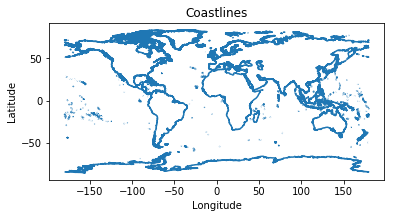

In [7]:
coastline_df.plot()
plt.title('Coastlines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We recognize the coastlines on Earth. We will do the following : From our data set containing the temperatures, we will build a new one containing for each city its coordinates as a geometric `POINT` object. Once we have done this, we can use the `.distance()` function from `geopandas` which will minimize the distance between the cities and the coastlines.

In [8]:
## Download the temperature data set
temperature_df = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [9]:
temperature_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


We just have to transform the coordinates columns (we explain this step in the Notebook DataPreparation.ipynb).

In [10]:
## Change Coordinates
def ChangeCoord(string):
    ## North or East
    if ('N' in string) or ('E' in string):
        return string[0:-1]
    ## South or West
    elif ('S' in string) or ('W' in string):
        newstring = '-'+string[0:-1]
        return newstring

## Apply the function to coordinates
temperature_df['Latitude'] = temperature_df['Latitude'].apply(ChangeCoord)
temperature_df['Longitude']=temperature_df['Longitude'].apply(ChangeCoord)
## Change the dtype
temperature_df['Longitude'] = temperature_df['Longitude'].astype(np.float)
temperature_df['Latitude'] = temperature_df['Latitude'].astype(np.float)

In [11]:
## The dataframe of all cities with their coordinates
cities_df = temperature_df.groupby('City').mean()

In [12]:
cities_df.head()

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude
City,,,,
A Coruña,13.147277,1.487352,42.59,-8.73
Aachen,8.825173,1.617299,50.63,6.34
Aalborg,7.695135,1.668720,57.05,10.33
Aba,26.612824,0.644945,5.63,8.07
Abadan,25.034749,0.953450,29.74,48.00


We now add a column containing the coordinates as geometric object (`POINT`).

In [13]:
cities_geodf = gpd.GeoDataFrame(
    cities_df, geometry=gpd.points_from_xy(cities_df.Longitude, 
                                            cities_df.Latitude),
crs={'init':'epsg:4326'})

/Users/raphaelzacharias/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
cities_geodf.head()

,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,geometry
City,,,,,
A Coruña,13.147277,1.487352,42.59,-8.73,POINT (-8.73000 42.59000)
Aachen,8.825173,1.617299,50.63,6.34,POINT (6.34000 50.63000)
Aalborg,7.695135,1.668720,57.05,10.33,POINT (10.33000 57.05000)
Aba,26.612824,0.644945,5.63,8.07,POINT (8.07000 5.63000)
Abadan,25.034749,0.953450,29.74,48.00,POINT (48.00000 29.74000)


In [16]:
## Change the coordinates system to get a distance in meter and not in degree
cities_geodf.to_crs(epsg=3310,inplace=True)
coastline_df.to_crs(epsg=3310,inplace=True)


In [17]:
results = []
## Loop over the cities
for i in range(len(cities_geodf)):
    city_name = cities_geodf.index[i]
    ## Its coordinates
    city_coord = cities_geodf.iloc[i,4]
    
    ## Store all distances from this city to coastlines
    distances = []
    ## Loop over the coastlines
    for j in range(len(coastline_df)):
        ## The linestring
        linestring = coastline_df.iloc[j,3]
        ## The distance between the city and this linestring
        d = city_coord.distance(linestring)
        ## Store the result
        distances.append(d)
    ## Compute the minimum of the distances
    d_min = np.min(distances)
    ## Construct a DataFrame containing for each city the minimal distance
    results.append({
        'City':city_name,
        'Distance to ocean':d_min
    })
dist_ocean_df = pd.DataFrame(results)

In [18]:
dist_ocean_df.head()

,City,Distance to ocean
0,A Coruña,4084.890091
1,Aachen,162610.022319
2,Aalborg,2598.928645
3,Aba,64247.212994
4,Abadan,4301.465695


In [34]:
## Create a csv file
####################
dist_ocean_df.to_csv('distance_ocean.csv',index=False,encoding='utf-8')